<a href="https://colab.research.google.com/github/jueunkim99/DataAnalysis/blob/main/%5B221015%5DMusinsa_recommendersystem_trial3%2Bgroup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Musinsa standard top1 item by review size 
* recommender system trial
* for boaz

## 환경설정

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/BOAZ/분석adv

/content/drive/MyDrive/BOAZ/분석adv


In [3]:
pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 8.0 MB/s 
     |████████████████████████████████| 453 kB 60.1 MB/s 


In [4]:
# 데이터 조작 관련
import pandas as pd
import numpy as np
import seaborn as sns
import re
import io
from sklearn.metrics.pairwise import cosine_similarity

# 한국어 nlp
from konlpy.tag import *   # 모든 형태소분석기 import 하기
#1. hannanum = Hannanum()
#2. kkma = Kkma()
#3. komoran = Komoran()
#4. okt = Okt()

okt = Okt()

### 위 4개중 원하는 형태소분석기를 사용하면 됨 --> okt추천

# 영어 nlp 관련
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

# 시각화 관련
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image

# 기타
from tqdm import tqdm_notebook, tqdm   # for문 진행상황 눈으로 확인 (loading bar)
import datetime

## 파일불러오기
* 참고사진 from 다정

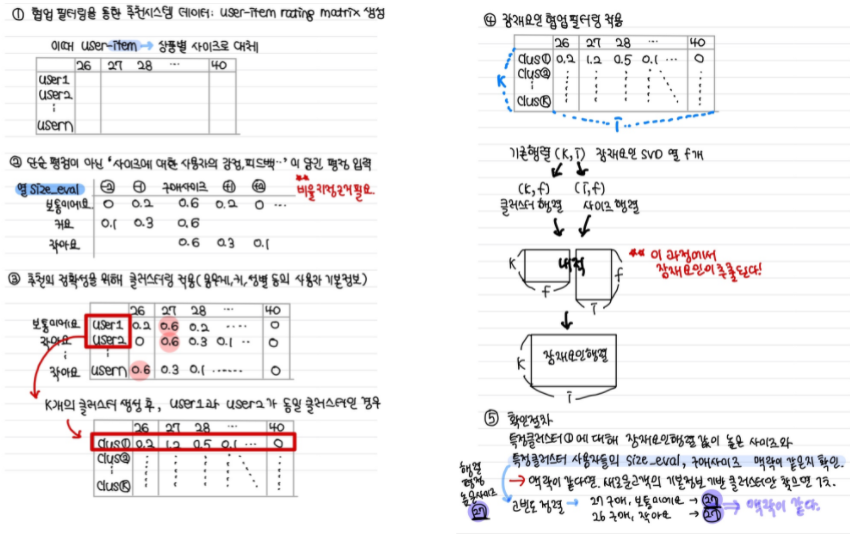

### 기본

In [46]:
df = pd.read_csv('무탠다드_top1_테이퍼드 히든 밴딩 크롭 슬랙스4943개.csv')

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4944 entries, 0 to 4943
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   4944 non-null   int64 
 1   user         4944 non-null   object
 2   gender       4944 non-null   object
 3   height       4944 non-null   object
 4   weight       4944 non-null   object
 5   item         4944 non-null   object
 6   size         4944 non-null   int64 
 7   star         4944 non-null   int64 
 8   content      4944 non-null   object
 9   size_eval    4944 non-null   object
 10  bright_eval  4944 non-null   object
 11  color_eval   4944 non-null   object
 12  thick_eval   4944 non-null   object
dtypes: int64(3), object(10)
memory usage: 502.2+ KB


In [48]:
df["size_eval"]=df["size_eval"].replace('보통이에요','0',regex = True)
df["size_eval"]=df["size_eval"].replace('커요','1',regex = True)
df["size_eval"]=df["size_eval"].replace('작아요','-1',regex = True)
df["height"]=df["height"].replace('cm','',regex = True)
df["weight"]=df["weight"].replace('kg','',regex = True)
df["height"] = pd.to_numeric(df["height"])
df["weight"] = pd.to_numeric(df["weight"])
df["size_eval"] = pd.to_numeric(df["size_eval"])
df.head()

,Unnamed: 0,user,gender,height,weight,item,size,star,content,size_eval,bright_eval,color_eval,thick_eval
0,0,LV 3 뉴비_f68324b5,남성,174,73,테이퍼드 히든 밴딩 크롭 슬랙스 [차콜 그레이],31,5,원래 핏하게 입는데요 31사이즈 딱 좋습니다 예뻐요!,0,보통이에요,보통이에요,보통이에요
1,1,LV 3 sup1234,남성,168,67,테이퍼드 히든 밴딩 크롭 슬랙스 [다크 그레이],32,5,기본 테이퍼드 슬랙스로 적합합니다. 기본 바지 없으신 분들께 추천드려요!,0,보통이에요,보통이에요,보통이에요
2,2,LV 3 sup1234,남성,168,67,테이퍼드 히든 밴딩 크롭 슬랙스 [라이트 베이지],32,5,기본 테이퍼드 슬랙스로 적합합니다. 기본 바지 없으신 분들께 추천드려요!,0,보통이에요,보통이에요,보통이에요
3,3,LV 3 sup1234,남성,168,67,테이퍼드 히든 밴딩 크롭 슬랙스 [블랙],32,5,기본 테이퍼드 슬랙스로 적합합니다. 기본 바지 없으신 분들께 추천드려요!,0,보통이에요,보통이에요,보통이에요
4,4,LV 5 취월,남성,178,87,테이퍼드 히든 밴딩 크롭 슬랙스 [블랙],38,3,허리가 사이즈 너무 크게 나오긴하는데.. 가성비는 좋습니다.,1,보통이에요,보통이에요,보통이에요


### 전처리 for cluster

In [56]:
df_cluster = df.drop(['item','content','bright_eval','color_eval','thick_eval','Unnamed: 0','user','gender','star'],axis = 1)
df_cluster.head()

,height,weight,size,size_eval
0,174,73,31,0
1,168,67,32,0
2,168,67,32,0
3,168,67,32,0
4,178,87,38,1


In [57]:
#키와 몸무게 확인
df_cluster.describe()

,height,weight,size,size_eval
count,4944.000000,4944.000000,4944.000000,4944.000000
mean,169.718447,68.394822,31.529531,0.117516
std,8.600233,9.611630,2.219937,0.369460
min,150.000000,40.000000,26.000000,-1.000000
25%,168.000000,66.000000,31.000000,0.000000
50%,170.000000,68.000000,32.000000,0.000000
75%,174.000000,72.000000,33.000000,0.000000
max,189.000000,110.000000,40.000000,1.000000


* height : 150 ~ 189, 50% = 170
* weight : 40 ~ 110, 50% = 68

  * 키 범주화 150 ~ 155/ 155 ~ 160/ 161 ~ 165/ 165 ~ 170/ 170 ~ 175/ 175 ~ 180/ 181 ~ 185/ 185 ~ 
   * 차례로 1,2,3,4,5,6,7,8
  * 몸무게 범주화 40 ~ 50/ 50 ~ 60/ 60 ~ 70/ 70 ~ 80/ 80 ~ 90/ 90 ~ 100/ 100 ~ 
   * 차례로 1,2,3,4,5,6,7

In [58]:
df_cluster.loc[(df_cluster['height'] >=150) & (df_cluster['height'] < 155),'height_num'] = '1'
df_cluster.loc[(df_cluster['height'] >=155) & (df_cluster['height'] < 160),'height_num'] = '2'
df_cluster.loc[(df_cluster['height'] >=160) & (df_cluster['height'] < 165),'height_num'] = '3'
df_cluster.loc[(df_cluster['height'] >=165) & (df_cluster['height'] < 170),'height_num'] = '4'
df_cluster.loc[(df_cluster['height'] >=170) & (df_cluster['height'] < 175),'height_num'] = '5'
df_cluster.loc[(df_cluster['height'] >=175) & (df_cluster['height'] < 180),'height_num'] = '6'
df_cluster.loc[(df_cluster['height'] >=180) & (df_cluster['height'] < 185),'height_num'] = '7'
df_cluster.loc[(df_cluster['height'] >=185),'height_num'] = '8'

df_cluster.loc[(df_cluster['weight'] >=40) & (df_cluster['weight'] < 50),'weight_num'] = '1'
df_cluster.loc[(df_cluster['weight'] >=50) & (df_cluster['weight'] < 60),'weight_num'] = '2'
df_cluster.loc[(df_cluster['weight'] >=60) & (df_cluster['weight'] < 70),'weight_num'] = '3'
df_cluster.loc[(df_cluster['weight'] >=70) & (df_cluster['weight'] < 80),'weight_num'] = '4'
df_cluster.loc[(df_cluster['weight'] >=80) & (df_cluster['weight'] < 90),'weight_num'] = '5'
df_cluster.loc[(df_cluster['weight'] >=90) & (df_cluster['weight'] < 100),'weight_num'] = '6'
df_cluster.loc[(df_cluster['weight'] >=100),'weight_num'] = '7'

df_cluster['height/weight'] = df_cluster['height_num']+'.'+ df_cluster['weight_num']


In [59]:
df_cluster = df_cluster.drop(['height','weight','height_num','weight_num'],axis = 1)

In [61]:
#해당상품의 사이즈 확인하고 리스트에 넣기, 무작정 1씩 올리기 금지!(34부터는 2씩증가하기 때문)
all_size = [26,27,28,29,30,31,32,33,34,36,38,40,42]
all_size_df = pd.DataFrame(np.zeros((df_cluster.shape[0], len(all_size))),columns = all_size)
df_cluster = pd.concat([df_cluster,all_size_df],axis = 1)


In [62]:
df_cluster.head()

,size,size_eval,height/weight,26,27,28,29,30,31,32,33,34,36,38,40,42
0,31,0,5.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,32,0,4.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,32,0,4.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,32,0,4.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,38,1,6.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
df_cluster.to_csv('before_cluster.csv')

## 점수 파일 생성
**점수주기**,
**범주화별로 점수 더하기**

* 1 점기준
* '보통이에요' 일 경우
  * 구매사이즈-1: 0.2점, 구매사이즈: 0.6점, 구매사이즈+1: 0.2점
* '커요'일 경우 
  * 구매사이즈-2: 0.2점, 구매사이즈-1: 0.4점, 구매사이즈: 0.4점
* '작아요'일 경우 
  * 구매사이즈: 0.4점, 구매사이즈+1: 0.4점, 구매사이즈+2 : 0.2점

** 커요일 경우 그래도 입을 수 있고 맘에 안든다기 보다는 생각보다 크네~ 이정도일 수도 있음. 그러나 작아요일 경우 맘에안들고 안입게되는 경우가 커요에 비해 더 많다. 그래서 다르게 점수를 매겨야함->이후 추후논의 필요

** 사이즈표: 26,27,28,29,30,31,32,33,34,36,38,40,42

In [78]:
df = pd.read_csv('before_cluster.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4944 entries, 0 to 4943
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     4944 non-null   int64  
 1   size           4944 non-null   int64  
 2   size_eval      4944 non-null   int64  
 3   height/weight  4944 non-null   float64
 4   26             4944 non-null   float64
 5   27             4944 non-null   float64
 6   28             4944 non-null   float64
 7   29             4944 non-null   float64
 8   30             4944 non-null   float64
 9   31             4944 non-null   float64
 10  32             4944 non-null   float64
 11  33             4944 non-null   float64
 12  34             4944 non-null   float64
 13  36             4944 non-null   float64
 14  38             4944 non-null   float64
 15  40             4944 non-null   float64
 16  42             4944 non-null   float64
dtypes: float64(14), int64(3)
memory usage: 656.8 KB


In [79]:
df.head()

,Unnamed: 0,size,size_eval,height/weight,26,27,28,29,30,31,32,33,34,36,38,40,42
0,0,31,0,5.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,32,0,4.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,32,0,4.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,32,0,4.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,38,1,6.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
for i in range(0, df.shape[0]):
    try:
      if df['size'][i] == 26:
        if df['size_eval'][i]== 0:
            df[str(int(df['size'][i]))][i]=0.6#구매사이즈
            df[str(int(df['size'][i])+1)][i]=0.2#구매사이즈+1
            #df[str(int(df['size'][i])-1)][i]=0.2#구매사이즈-1
        elif df['size_eval'][i]==1:
            df[str(int(df['size'][i]))][i]=0.4#구매사이즈
            #df[str(int(df['size'][i])-1)][i]=0.4#구매사이즈-1
            #df[str(int(df['size'][i])-2)][i]=0.2#구매사이즈-2
        elif df['size_eval'][i]==-1:
            df[str(int(df['size'][i]))][i]=0.4#구매사이즈
            df[str(int(df['size'][i])+1)][i]=0.4#구매사이즈+1
            df[str(int(df['size'][i])+2)][i]=0.2#구매사이즈+2

      elif df['size'][i] ==27:
        if df['size_eval'][i]== 0:
            df[str(int(df['size'][i]))][i]=0.6#구매사이즈
            df[str(int(df['size'][i])+1)][i]=0.2#구매사이즈+1
            df[str(int(df['size'][i])-1)][i]=0.2#구매사이즈-1
        elif df['size_eval'][i]==1:
            df[str(int(df['size'][i]))][i]=0.4#구매사이즈
            df[str(int(df['size'][i])-1)][i]=0.4#구매사이즈-1
            #df[str(int(df['size'][i])-2)][i]=0.2#구매사이즈-2
        elif df['size_eval'][i]==-1:
            df[str(int(df['size'][i]))][i]=0.4#구매사이즈
            df[str(int(df['size'][i])+1)][i]=0.4#구매사이즈+1
            df[str(int(df['size'][i])+2)][i]=0.2#구매사이즈+2

      elif (df['size'][i] >27) & (df['size'][i] < 33):
        if df['size_eval'][i]== 0:
            df[str(int(df['size'][i]))][i]=0.6#구매사이즈
            df[str(int(df['size'][i])+1)][i]=0.2#구매사이즈+1
            df[str(int(df['size'][i])-1)][i]=0.2#구매사이즈-1
        elif df['size_eval'][i]==1:
            df[str(int(df['size'][i]))][i]=0.4#구매사이즈
            df[str(int(df['size'][i])-1)][i]=0.4#구매사이즈-1
            df[str(int(df['size'][i])-2)][i]=0.2#구매사이즈-2
        elif df['size_eval'][i]==-1:
            df[str(int(df['size'][i]))][i]=0.4#구매사이즈
            df[str(int(df['size'][i])+1)][i]=0.4#구매사이즈+1
            df[str(int(df['size'][i])+2)][i]=0.2#구매사이즈+2

      elif df['size'][i] == 33:
        if df['size_eval'][i]== 0:
            df[str(int(df['size'][i]))][i]=0.6#구매사이즈
            df[str(int(df['size'][i])+1)][i]=0.2#구매사이즈+1
            df[str(int(df['size'][i])-1)][i]=0.2#구매사이즈-1
        elif df['size_eval'][i]==1:
            df[str(int(df['size'][i]))][i]=0.4#구매사이즈
            df[str(int(df['size'][i])-1)][i]=0.4#구매사이즈-1
            df[str(int(df['size'][i])-2)][i]=0.2#구매사이즈-2
        elif df['size_eval'][i]==-1:
            df[str(int(df['size'][i]))][i]=0.4#구매사이즈
            df[str(int(df['size'][i])+1)][i]=0.4#구매사이즈+1
            df[str(int(df['size'][i])+3)][i]=0.2#구매사이즈+2

      elif df['size'][i] ==34:
        if df['size_eval'][i]== 0:
            df[str(int(df['size'][i]))][i]=0.6#구매사이즈
            df[str(int(df['size'][i])+2)][i]=0.2#구매사이즈+1
            df[str(int(df['size'][i])-1)][i]=0.2#구매사이즈-1
        elif df['size_eval'][i]==1:
            df[str(int(df['size'][i]))][i]=0.4#구매사이즈
            df[str(int(df['size'][i])-1)][i]=0.4#구매사이즈-1
            df[str(int(df['size'][i])-2)][i]=0.2#구매사이즈-2
        elif df['size_eval'][i]==-1:
            df[str(int(df['size'][i]))][i]=0.4#구매사이즈
            df[str(int(df['size'][i])+2)][i]=0.4#구매사이즈+1
            df[str(int(df['size'][i])+4)][i]=0.2#구매사이즈+2

      elif (df['size'][i] >= 36) & (df['size'][i] < 40):
        if df['size_eval'][i]== 0:
            df[str(int(df['size'][i]))][i]=0.6#구매사이즈
            df[str(int(df['size'][i])+2)][i]=0.2#구매사이즈+1
            df[str(int(df['size'][i])-2)][i]=0.2#구매사이즈-1
        elif df['size_eval'][i]==1:
            df[str(int(df['size'][i]))][i]=0.4#구매사이즈
            df[str(int(df['size'][i])-2)][i]=0.4#구매사이즈-1
            df[str(int(df['size'][i])-4)][i]=0.2#구매사이즈-2
        elif df['size_eval'][i]==-1:
            df[str(int(df['size'][i]))][i]=0.4#구매사이즈
            df[str(int(df['size'][i])+2)][i]=0.4#구매사이즈+1
            df[str(int(df['size'][i])+4)][i]=0.2#구매사이즈+2

      elif df['size'][i] == 40:
        if df['size_eval'][i]== 0:
            df[str(int(df['size'][i]))][i]=0.6#구매사이즈
            df[str(int(df['size'][i])+2)][i]=0.2#구매사이즈+1
            df[str(int(df['size'][i])-2)][i]=0.2#구매사이즈-1
        elif df['size_eval'][i]==1:
            df[str(int(df['size'][i]))][i]=0.4#구매사이즈
            df[str(int(df['size'][i])-2)][i]=0.4#구매사이즈-1
            df[str(int(df['size'][i])-4)][i]=0.2#구매사이즈-2
        elif df['size_eval'][i]==-1:
            df[str(int(df['size'][i]))][i]=0.4#구매사이즈
            df[str(int(df['size'][i])+2)][i]=0.4#구매사이즈+1
            #df[str(int(df['size'][i])+4)][i]=0.2#구매사이즈+2
      
      elif df['size'][i] ==42:
        if df['size_eval'][i]== 0:
            df[str(int(df['size'][i]))][i]=0.6#구매사이즈
            #df[str(int(df['size'][i])+1)][i]=0.2#구매사이즈+1
            df[str(int(df['size'][i])-2)][i]=0.2#구매사이즈-1
        elif df['size_eval'][i]==-1:
            df[str(int(df['size'][i]))][i]=0.4#구매사이즈
            #df[str(int(df['size'][i])+1)][i]=0.4#구매사이즈+1
            #df[str(int(df['size'][i])+2)][i]=0.2#구매사이즈+2          
        elif df['size_eval'][i]==1:
            df[str(int(df['size'][i]))][i]=0.4#구매사이즈
            df[str(int(df['size'][i])-2)][i]=0.4#구매사이즈-1
            df[str(int(df['size'][i])-4)][i]=0.2#구매사이즈-2

    except Exception as e:
      print(e)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to b

In [86]:
#점수배분완료->확인
df.head(10)

,Unnamed: 0,size,size_eval,height/weight,26,27,28,29,30,31,32,33,34,36,38,40,42
0,0,31,0,5.4,0.0,0.0,0.0,0.0,0.2,0.6,0.2,0.0,0.0,0.0,0.0,0.0,0.0
1,1,32,0,4.3,0.0,0.0,0.0,0.0,0.0,0.2,0.6,0.2,0.0,0.0,0.0,0.0,0.0
2,2,32,0,4.3,0.0,0.0,0.0,0.0,0.0,0.2,0.6,0.2,0.0,0.0,0.0,0.0,0.0
3,3,32,0,4.3,0.0,0.0,0.0,0.0,0.0,0.2,0.6,0.2,0.0,0.0,0.0,0.0,0.0
4,4,38,1,6.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.4,0.4,0.0,0.0
5,5,34,0,5.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.6,0.2,0.0,0.0,0.0
6,6,29,0,3.2,0.0,0.0,0.2,0.6,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,29,0,3.2,0.0,0.0,0.2,0.6,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8,29,0,3.3,0.0,0.0,0.2,0.6,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,9,34,0,7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.6,0.2,0.0,0.0,0.0


In [88]:
final_df=df.groupby(['height/weight'])['26','27','28','29','30','31','32','33','34','36','38','40','42'].sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [91]:
final_df

,26,27,28,29,30,31,32,33,34,36,38,40,42
height/weight,,,,,,,,,,,,,
1.2,257.6,257.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.1,0.8,1.6,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.2,0.0,0.0,0.0,0.4,0.4,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.2,2.4,2.0,2.4,2.6,0.8,0.2,0.6,0.2,0.0,0.0,0.0,0.0,0.0
3.3,0.0,0.0,0.6,2.6,3.8,1.0,0.0,0.4,1.2,0.4,0.0,0.0,0.0
3.4,0.0,0.0,0.0,0.0,0.2,0.6,0.2,0.0,0.0,0.0,0.0,0.0,0.0
4.1,1.0,1.8,0.8,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.2,2.6,7.0,9.8,7.8,7.2,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.3,0.0,1.0,3.8,9.6,17.0,18.0,140.4,390.0,129.2,0.0,0.0,0.0,0.0


In [90]:
final_df.to_csv('after_cluster.csv')

## 추천시스템 구현(진행중)
* 구현한 것: 사용자 본인의 몸무게와 키의 범주 검색-> 사이즈추천

* 고민한것
1. 사용자와 키와 몸무게가 범주의 그룹이 없다면 검색불가->후에 추가해야함


In [93]:
df = pd.read_csv('after_cluster.csv')
df.fillna(0,inplace = True)
df.head()

,height/weight,26,27,28,29,30,31,32,33,34,36,38,40,42
0,1.2,257.6,257.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.1,0.8,1.6,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.2,0.0,0.0,0.0,0.4,0.4,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.2,2.4,2.0,2.4,2.6,0.8,0.2,0.6,0.2,0.0,0.0,0.0,0.0,0.0
4,3.3,0.0,0.0,0.6,2.6,3.8,1.0,0.0,0.4,1.2,0.4,0.0,0.0,0.0


In [95]:
df=df.set_index(keys= 'height/weight')
df.head()

,26,27,28,29,30,31,32,33,34,36,38,40,42
height/weight,,,,,,,,,,,,,
1.2,257.6,257.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.1,0.8,1.6,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.2,0.0,0.0,0.0,0.4,0.4,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.2,2.4,2.0,2.4,2.6,0.8,0.2,0.6,0.2,0.0,0.0,0.0,0.0,0.0
3.3,0.0,0.0,0.6,2.6,3.8,1.0,0.0,0.4,1.2,0.4,0.0,0.0,0.0


## 비고(참고링크)
* https://tpwkcorqhd.tistory.com/37
* 여러값 바꾸기 참고: https://developer-ping9.tistory.com/111 : 
 * df[df['주거형태']=='자가', 'X'] =1

* 영화 추천시스템: https://lsjsj92.tistory.com/570 
* SVD U,sigma, Vt 설명: https://sungkee-book.tistory.com/12

* https://romg2.github.io/mlguide/02_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C-09.-%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C-%EC%B5%9C%EA%B7%BC%EC%A0%91-%EC%9D%B4%EC%9B%83/
* 잠재요인필터링설명 : https://romg2.github.io/mlguide/01_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C-09.-%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C-%EC%9E%A0%EC%9E%AC-%EC%9A%94%EC%9D%B8/

In [ ]:
#df["size_eval"] = pd.to_numeric(df["size_eval"])
#df["size_eval"]=df["size_eval"].replace('보통이에요','0',regex = True)
#df["size_eval"]=df["size_eval"].replace('커요','1',regex = True)
#df["size_eval"]=df["size_eval"].replace('작아요','-1',regex = True)

## SVD 참고

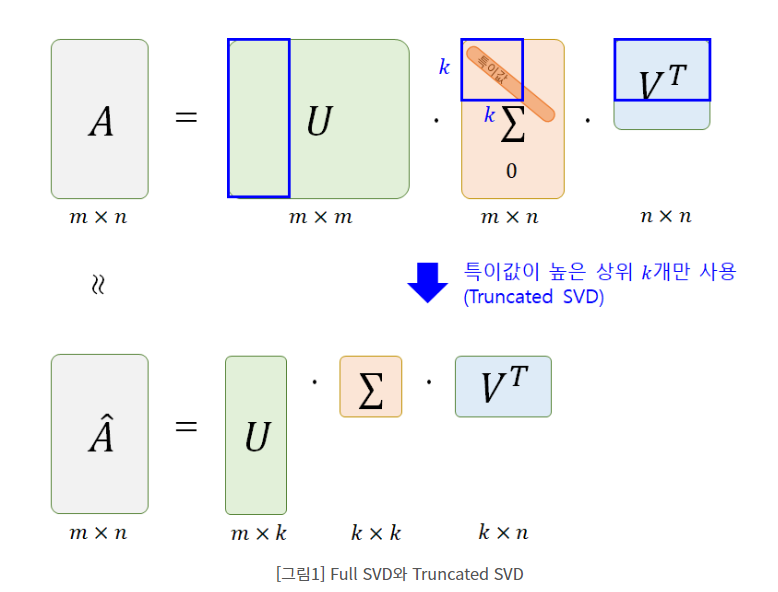

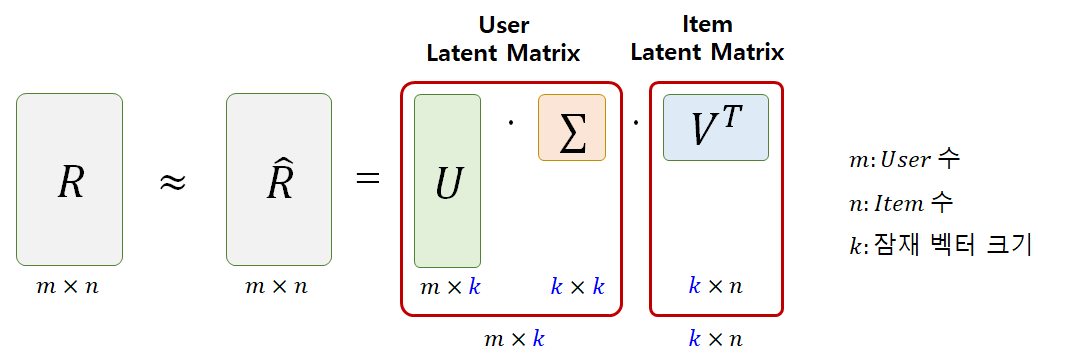